# Time Series Forecasting 

### Next day Max temperature for Seoul  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('Bias_correction_ucl.csv',parse_dates=['Date'])
df = df[df['station'].notna()]
df['station'] = df['station'].astype(int)
df = df.interpolate(method='bfill')
df.head(5)

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [3]:
df.dtypes

station                      int32
Date                datetime64[ns]
Present_Tmax               float64
Present_Tmin               float64
LDAPS_RHmin                float64
LDAPS_RHmax                float64
LDAPS_Tmax_lapse           float64
LDAPS_Tmin_lapse           float64
LDAPS_WS                   float64
LDAPS_LH                   float64
LDAPS_CC1                  float64
LDAPS_CC2                  float64
LDAPS_CC3                  float64
LDAPS_CC4                  float64
LDAPS_PPT1                 float64
LDAPS_PPT2                 float64
LDAPS_PPT3                 float64
LDAPS_PPT4                 float64
lat                        float64
lon                        float64
DEM                        float64
Slope                      float64
Solar radiation            float64
Next_Tmax                  float64
Next_Tmin                  float64
dtype: object

In [4]:
df.isna().sum()

station             0
Date                0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

## Time Series Analysis

- The Dataset consist in a group of 25 Time Series Gathered from 25 weather Stations in Korea. The main Ideia here is to analyze the similarity between the data of each station to the others

we will start doing it by the target Feature

In [5]:
df_Tmax = pd.DataFrame()

for station in df.station.unique():
    tmax = np.array(df[df['station']==station]['Next_Tmax'])
    df_Tmax[station] = tmax

df_Tmax.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,29.1,30.5,31.1,31.7,31.2,31.5,30.9,31.1,31.3,30.5,...,30.8,31.5,33.1,31.8,30.8,30.6,32.6,31.8,31.3,32.0
1,24.8,27.3,28.1,27.9,28.2,28.9,27.6,28.2,27.1,27.5,...,27.5,27.8,29.2,27.1,27.3,28.2,29.1,28.1,28.2,28.8
2,28.1,30.8,31.2,31.3,31.3,31.3,30.0,30.0,30.1,29.4,...,30.1,31.4,32.6,30.5,30.6,30.5,32.5,31.2,30.5,31.0
3,25.2,28.4,28.2,28.4,28.7,28.3,27.1,27.1,27.4,26.2,...,26.7,28.6,29.4,27.4,27.7,27.6,28.5,27.6,27.7,27.9
4,28.0,30.0,30.8,30.6,32.6,31.1,30.7,30.5,29.6,30.0,...,29.3,30.1,32.2,30.2,29.9,30.4,30.5,31.3,31.5,31.4


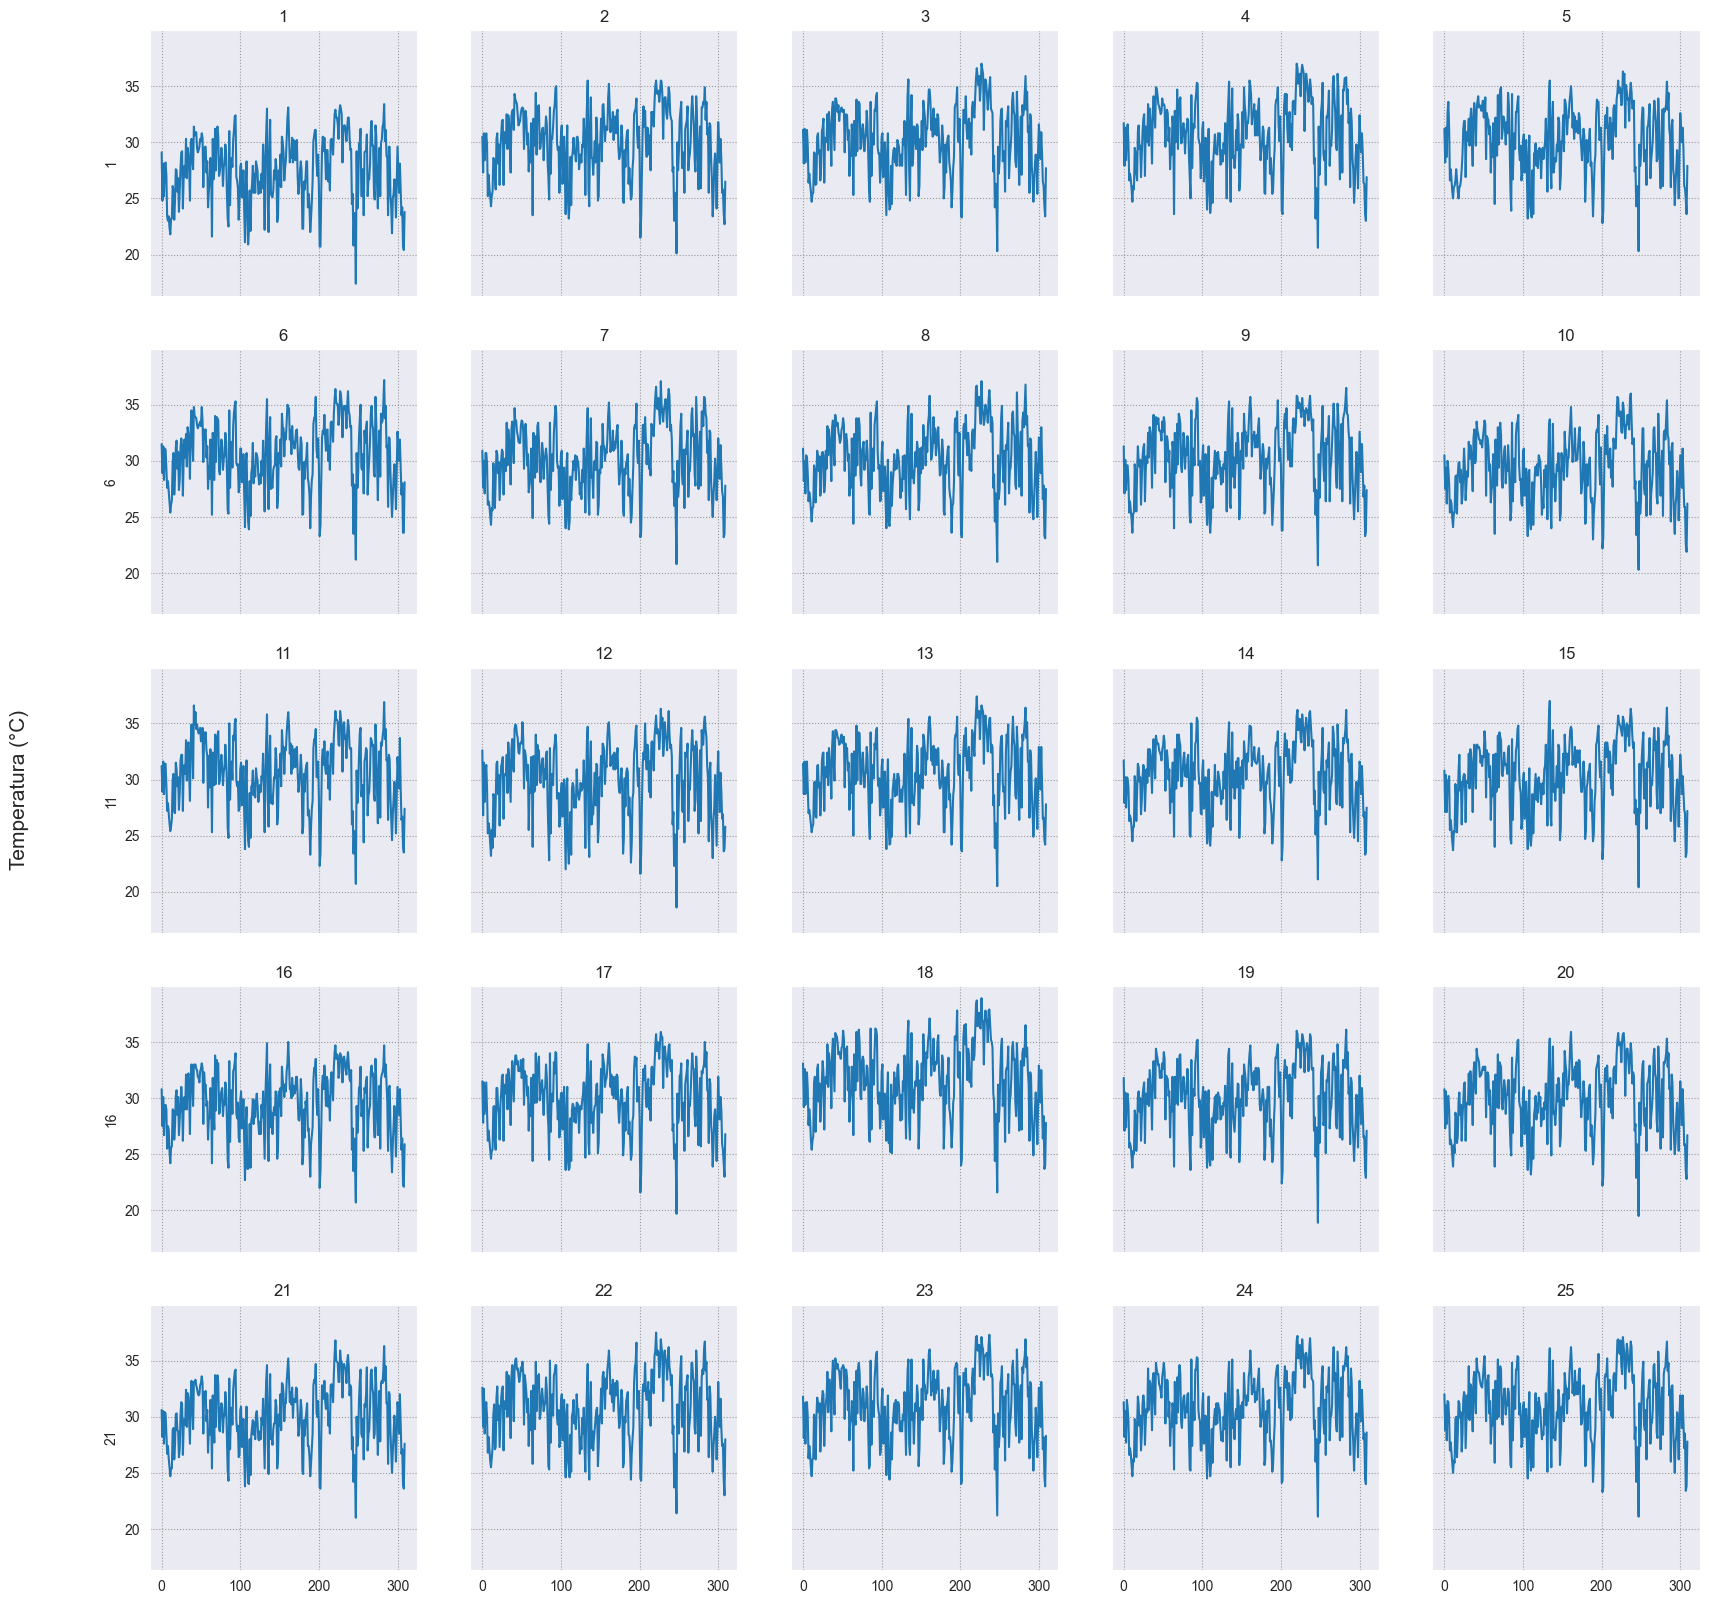

In [6]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(20, 20))
#ax[4].tick_params(axis='both', which='major', labelsize=11)
#ax[4].tick_params(axis='both', which='minor', labelsize=10)
fig.text(0.06, 0.5, 'Temperatura (°C)', ha='center',
         va='center', rotation='vertical', fontsize=15)
#fig.text(0.5, 0.11, 'Data', ha='center', va='center',fontsize = 12)

for i,pos in enumerate(list(itertools.product(range(5),range(5)))):
    ax[pos[0],pos[1]].set_title(str(i+1))
    sns.lineplot(ax=ax[pos[0],pos[1]], data = df_Tmax[i+1])


<AxesSubplot: >

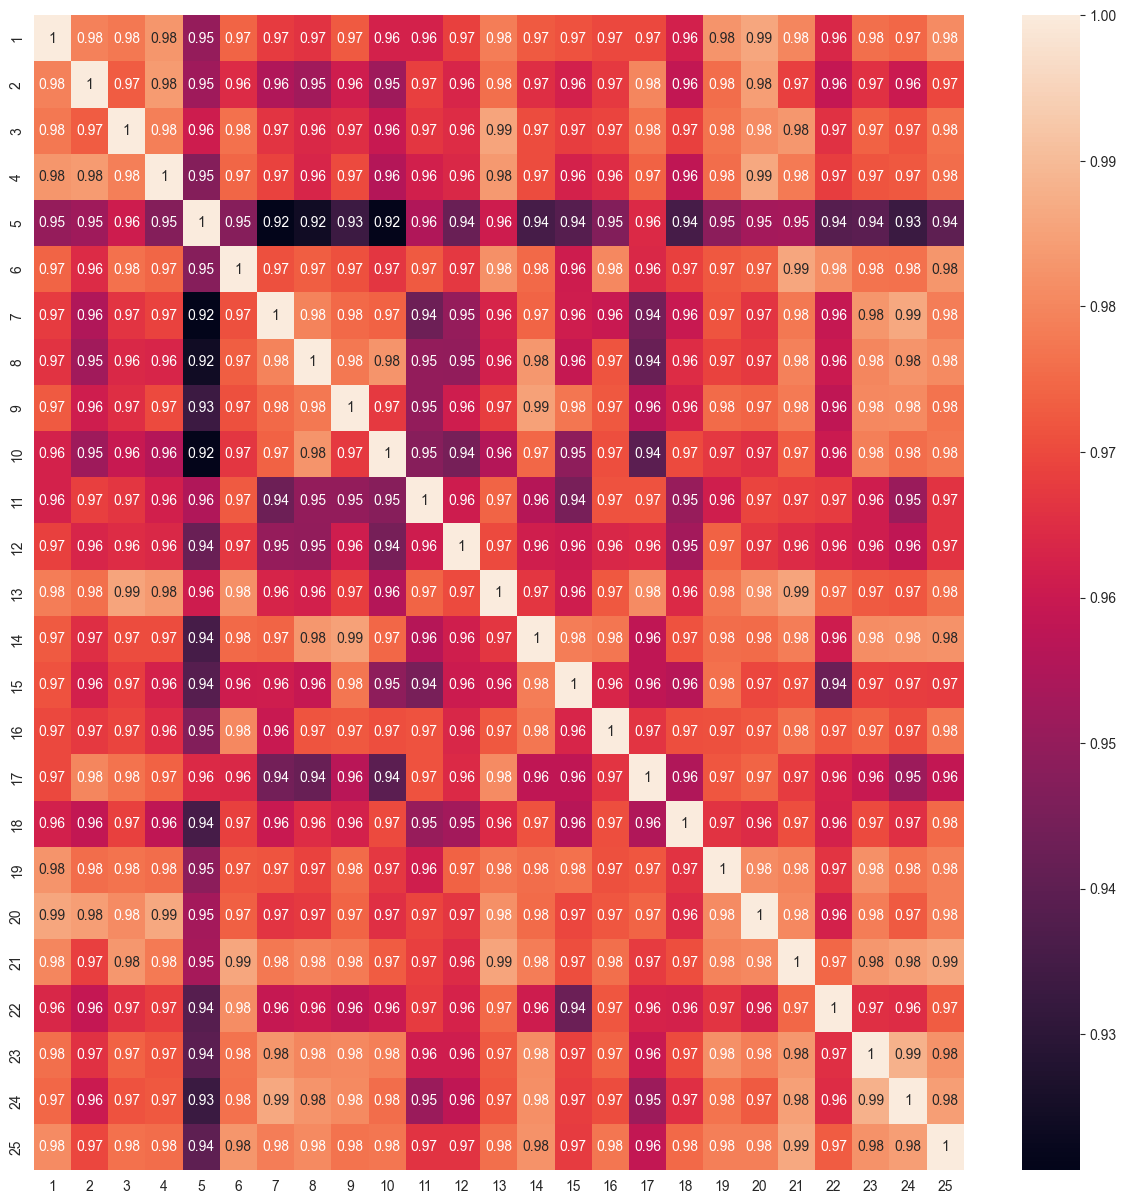

In [7]:
corr = df_Tmax.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True)

In [8]:
corr_mean = {}
for col in df.columns:
    df_aux = pd.DataFrame()
    for station in df.station.unique():
        feature_values = np.array(df[df['station']==station][col])
        df_aux[station] = feature_values
    corr_mean[col] = df_aux.corr().mean().mean()

corr_mean

C:\Users\A457172\AppData\Local\Temp\ipykernel_9140\2200209626.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mean[col] = df_aux.corr().mean().mean()


{'station': nan,
 'Date': nan,
 'Present_Tmax': 0.9653148693438728,
 'Present_Tmin': 0.9401764473203547,
 'LDAPS_RHmin': 0.9669895638755137,
 'LDAPS_RHmax': 0.8551548279860891,
 'LDAPS_Tmax_lapse': 0.9790838027932232,
 'LDAPS_Tmin_lapse': 0.9729494014619648,
 'LDAPS_WS': 0.9339779251880119,
 'LDAPS_LH': 0.5287467489409932,
 'LDAPS_CC1': 0.9810367355033853,
 'LDAPS_CC2': 0.9820479266969967,
 'LDAPS_CC3': 0.9735652433705932,
 'LDAPS_CC4': 0.9778768164678076,
 'LDAPS_PPT1': 0.8454433717889733,
 'LDAPS_PPT2': 0.9073436842971705,
 'LDAPS_PPT3': 0.7407944694877914,
 'LDAPS_PPT4': 0.8118002688607874,
 'lat': nan,
 'lon': nan,
 'DEM': nan,
 'Slope': nan,
 'Solar radiation': 0.9999960996856921,
 'Next_Tmax': 0.9687261414255175,
 'Next_Tmin': 0.9434692712245178}

### Cluster Time Series

In [9]:
data_array = np.array(df_Tmax.T.values)
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(data_array)
y=model.predict(data_array)
y

c:\Users\A457172\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 25 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


array([1, 1, 2, 0, 1, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 1, 1, 0, 1, 1, 2, 0,
       0, 0, 0], dtype=int64)

In [10]:
ts_clusters = pd.DataFrame(columns=['station','cluster'],data=zip(range(1,26),y))
ts_clusters.cluster.value_counts()

1    9
0    9
2    7
Name: cluster, dtype: int64

## Using Cluster 1 to Make predictions

In [138]:
df_one = df[df.station.isin(ts_clusters[ts_clusters['cluster']==1]['station'])]
#df_one = df
print(df_one.station.unique())
df_one = df_one.set_index(['Date','station'])

[ 1  2  5 10 12 16 17 19 20]


In [139]:
feature_list = df_one.columns.to_list()
feature_list.remove('Next_Tmin')
feature_list.remove('Next_Tmax')
feature_list.remove('LDAPS_LH')
feature_list.remove('LDAPS_PPT1')
feature_list.remove('LDAPS_PPT2')
feature_list.remove('LDAPS_PPT3')
feature_list.remove('LDAPS_PPT4')

In [140]:
X = df_one[feature_list]
y = df_one['Next_Tmax']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)

In [141]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [142]:
n_input = len(feature_list)
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(n_input,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train.ravel(), epochs=1000, verbose=1)

Epoch 1/1000
70/70 [==============================] - 1s 1ms/step - loss: 85110.1641
Epoch 2/1000
70/70 [==============================] - 0s 1ms/step - loss: 86.9395
Epoch 3/1000
70/70 [==============================] - 0s 2ms/step - loss: 11.4759
Epoch 4/1000
70/70 [==============================] - 0s 2ms/step - loss: 11.2095
Epoch 5/1000
70/70 [==============================] - 0s 1ms/step - loss: 10.9884
Epoch 6/1000
70/70 [==============================] - 0s 1ms/step - loss: 10.7878
Epoch 7/1000
70/70 [==============================] - 0s 2ms/step - loss: 10.5856
Epoch 8/1000
70/70 [==============================] - 0s 1ms/step - loss: 10.3922
Epoch 9/1000
70/70 [==============================] - 0s 1ms/step - loss: 10.0808
Epoch 10/1000
70/70 [==============================] - 0s 2ms/step - loss: 9.8719
Epoch 11/1000
70/70 [==============================] - 0s 1ms/step - loss: 9.6195
Epoch 12/1000
70/70 [==============================] - 0s 1ms/step - loss: 9.5020
Epoch 13/1000

In [143]:
yfit = model.predict(X_test)

18/18 [==============================] - 0s 1ms/step


In [144]:
print("R-squared:",  r2_score(y_test,yfit))
print("MSE:", mean_squared_error(y_test,yfit))

R-squared: 0.6929013077790369
MSE: 2.9756486399711988


### Using LSTM

https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py

In [154]:
X_train_LSTM = []
n_past = 5

for i in range(n_past, len(X)):
    p1 = i - n_past
    p2 = X.shape[1]
    X_train_LSTM.append(X[i - n_past:i, 0:X.shape[1]])

y_train_LSTM = y[n_past:len(y)]

In [155]:
len(X_train_LSTM), len(X),len(y),len(y_train_LSTM)

(2785, 2790, 2790, 2785)

In [156]:
X_train_LSTM[0]

array([[0.56129032, 0.59763314, 0.47082747, 0.75913013, 0.55659084,
        0.60639282, 0.20744657, 0.24186184, 0.21055927, 0.16436136,
        0.13616988, 0.91661519, 0.26903553, 1.        , 0.48783359,
        1.        ],
       [0.76774194, 0.60946746, 0.39208323, 0.74525776, 0.65122364,
        0.67776853, 0.14805292, 0.23313707, 0.25999956, 0.16207144,
        0.13284079, 0.91661519, 0.47715736, 0.05484808, 0.00184048,
        0.92570319],
       [0.73548387, 0.62721893, 0.44347342, 0.73306777, 0.61197923,
        0.63968595, 0.15032508, 0.15652894, 0.25816542, 0.18184033,
        0.17682774, 0.58369364, 1.        , 0.        , 0.        ,
        0.91983545],
       [0.7483871 , 0.5443787 , 0.44974306, 0.64344447, 0.53009621,
        0.57307371, 0.19163391, 0.3600751 , 0.3162636 , 0.24929558,
        0.1408659 , 0.        , 0.08629442, 0.97840911, 1.        ,
        0.94030957],
       [0.7483871 , 0.64497041, 0.37927019, 0.46689223, 0.60251798,
        0.70074454, 0.18663532, 

In [157]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_train_LSTM), np.array(y_train_LSTM).reshape(-1,1), test_size=0.2,shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2228, 5, 16), (2228, 1), (557, 5, 16), (557, 1))

In [158]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(8, activation='relu', return_sequences=False))
model.add(Dense(8, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(X_train, y_train, epochs=50, verbose=1)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 5, 10)             1080      
                                                                 
 lstm_40 (LSTM)              (None, 8)                 608       
                                                                 
 dense_47 (Dense)            (None, 8)                 72        
                                                                 
 dense_48 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,769
Trainable params: 1,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
70/70 [==============================] - 3s 4ms/step - loss: 865.2867
Epoch 2/50
70/70 [==============================] - 0s 3ms/step - loss: 170.0160
Epoch 3/50
70/70 [===

In [159]:
yfit = model.predict(X_test)
yfit.shape

18/18 [==============================] - 0s 2ms/step


(557, 1)

In [160]:
print("R-squared:",  r2_score(y_test,yfit))
print("MSE:", mean_squared_error(y_test,yfit))

R-squared: 0.6000920805468608
MSE: 3.8818836387160176
